<h1> Black Box Optimizer v3.1: </h1>

+ Log Scale Random Number Through Manual Input<br>           
+ Multiple Stocks<br>
+ Multiple Alternatives<br>
+ Echo Machine File Output<br>
+ Table2Speech File Output<br>
+ Visualising Results as BoxPlot<br>
+ Visualising Results for each Metabolite<br>
+ Visualising Concentrations for each Day<br>
+ Find K Most Informative combinations<br>
+ Find Metabolite's Importance<br>
+ Find NonLinear Interactions<br>



In [ ]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
import time
from sklearn.model_selection import RandomizedSearchCV
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from collections.abc import Iterable
import math
import random
from scipy.stats import spearmanr, pearsonr

pd.options.mode.chained_assignment = None  # default='warn'
!wget https://raw.githubusercontent.com/amirpandi/METIS/main/utils.py

from utils import *

--2021-02-08 17:04:18--  https://raw.githubusercontent.com/myprogrammerpersonality/BlackBoxOptimizer/master/Functions_Final_v3_1.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22100 (22K) [text/plain]
Saving to: ‘Functions_Final_v3_1.py’

Functions_Final_v3_ 100%[===================>]  21.58K  --.-KB/s    in 0.001s  

2021-02-08 17:04:18 (15.1 MB/s) - ‘Functions_Final_v3_1.py’ saved [22100/22100]



# Help for each imported function is available:

In [ ]:
help(random_combination_generator)

Help on function random_combination_generator in module Functions_Final_v3_1:

random_combination_generator(concentrations_limits, number_of_combination=100, reaction_vol_nl=10000, max_nl=None, drop_size_nl=100, check_repeat=True, rounded=2, verbose=0, make_csv=False, return_df=False)
    this function make random combination that is safe (e.g. dont make too much or low concentrated, not excecutable based on drop size, not repetitive)
    
    Parameters
    ----------
    concentrations_limits : dict
        {'name of metabolite': {'Conc_Min': #, 'Conc_Max': #, 'Conc_Values': #, 'Conc_Stock': #, 'Alternatives': #}, ...}
        
    Returns
    -------
    data : pandas.DataFrame
        a dataframe as consist of number_of_combination of random combinations



This notebook includes all data processing, bayesian optimization and results visualisation

# User Inputs

<p1><h2> When to use this part:</h2>
* every time before using BBO you should fill this part based on your project</p1>
<p1><h2> How to use this part:</h2>
* User should upload all available Results file (i.e. Results_1.csv to Results_n.csv) to runtime from Files/UploadFile
* now there is an example, change it to your project</p1>

In [ ]:
# General Parameters:
m = 20      # number_of_combination_each_round
minimum_drop_size_nanoliter = 100
final_reaction_volume_nanoliter = 20000
maximum_volume_of_model_output = 9300 # (i. e., total volume minus fixed parts/components. Avoid 0 for water.)
fixed_parts = {'Lysate':0.33, 'EnergyBuffer':0.175, 'IPTG-Water':0.025} # 33% of total volume is Lysate, 15% energy mix (except variable one), 2.5% IPTG
days_total = 10 # how many days you want to continue # set it at your max prediction

# Model Parameters:
RandomCV = True
n_iter = 200
ensemble_len = 20 
exploration = {1: 0.5}
days_range = [m for i in range(days_total)]

In [ ]:
# Part 1: choose grid for our metabolite conc and define stock concentration

# It is recommended to first define the min and max conc, run this cell, see the concentrations generated by the model that are proportional to the stock concentration and the minimum pipetting volume. then from the suggested range choose the desired ones in conc_value and finally set min and max to None
# each metabolite min, max and stock must be in same units

# concentrations_limits :
# *** metabolite name must not includes "_" ***

concentrations_limits = {
 'PEG':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], 'Conc_Stock':50.0, 'Alternatives':None},
 'DTT':{'Conc_Min':0.0, 'Conc_Max':4.0, 'Conc_Values':None, 'Conc_Stock':100.0, 'Alternatives':None},
 'Spermidine':{'Conc_Min':0.2, 'Conc_Max':2.0, 'Conc_Values':None, 'Conc_Stock':40.0, 'Alternatives':None},
 'T7Pol':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.0], 'Conc_Stock':0.78, 'Alternatives':None},
 't-RNA':{'Conc_Min':0.04, 'Conc_Max':0.04, 'Conc_Values':None, 'Conc_Stock':8.0, 'Alternatives':None},
 'AminoAcids':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.75], 'Conc_Stock':6.0, 'Alternatives':None},
 'TF-plasmid':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.01, 0.02, 0.04, 0.08, 0.16, 0.32], 'Conc_Stock':2, 'Alternatives':None},
 'Circuit-plasmid':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[10.0], 'Conc_Stock':1000.0, 'Alternatives':['pTAC','pTHS','pDC','pSTAR']}}

In [ ]:
# Check Possible Concentrations
data_lists = {}
num = 0 

pool_size = 1

for key, value in concentrations_limits.items():
    print('Possible Conc For :',key)
    if not value['Conc_Values']:
        print('Your Min, Max :', "({}, {})".format(value['Conc_Min'], value['Conc_Max']))
    concs, vols = allowed_output(value, reaction_vol_nl = final_reaction_volume_nanoliter, drop_size_nl = minimum_drop_size_nanoliter, verbose=0)
    print(concs)
    print(vols)
    
    pool_size *= len(concs)

    data_lists[num] = vols
    num += 1
    print()

print('All Possible Combination Number = ', pool_size)
if pool_size > 10000000: 
    pool_size = 10000000
    print('Percentage calculation is not availbe duo to large pool size!')
else:
    percent , pool_size = percentage_possible(data_lists, threshold = maximum_volume_of_model_output)
    print(percent, f'% of {pool_size} possible combination are executable!')

Possible Conc For : PEG
[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
[400.0, 600.0, 800.0, 1000.0, 1200.0, 1400.0, 1600.0, 1800.0, 2000.0]

Possible Conc For : DTT
Your Min, Max : (0.0, 4.0)
[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
[0, 100, 200, 300, 400, 500, 600, 700, 800]

Possible Conc For : Spermidine
Your Min, Max : (0.2, 2.0)
[0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

Possible Conc For : T7Pol
[0.0]
[0.0]

Possible Conc For : t-RNA
Your Min, Max : (0.04, 0.04)
[0.04]
[100]

Possible Conc For : AminoAcids
[0.75]
[2500.0]

Possible Conc For : TF-plasmid
[0.01, 0.02, 0.04, 0.08, 0.16, 0.32]
[100.0, 200.0, 400.0, 800.0, 1600.0, 3200.0]

Possible Conc For : Circuit-plasmid
[10.0]
[200.0]

All Possible Combination Number =  4860
99.54732510288066 % of 4860 possible combination are executable!


In [ ]:
# add reference and negative control, these combinations will be implemented in concentrations and volume files
# leave it empty if you dont need, but still you need to run this cell
# you can add more desired combination to this dictionary
# *** conc in these dic must be compatible with minimum drop size ***, for help you can see our other examples on METIS Github repo 

specials = {}

# Day 1 (in absence of Day_0)

<p1><h2> When to use this part:</h2>
* after filling "User Input" if you have no pre existing data (Day_0.csv) 
<p1><h2> How to use this part:</h2>
* just run all cells!


In [ ]:
# make random combinations
Concentrations_1 = random_combination_generator(concentrations_limits, number_of_combination = m,
                                                reaction_vol_nl=final_reaction_volume_nanoliter,
                                                max_nl=maximum_volume_of_model_output, drop_size_nl=minimum_drop_size_nanoliter, return_df=True)

# add control, reference and other desired combinations
df_specials = [pd.DataFrame(i) for i in specials.values()]
Concentrations_1 = pd.concat([Concentrations_1, *df_specials]).reset_index(drop=True)

Concentrations_1

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,2.0,4.0,1.8,0.0507,0.04,0.75,60.0,10.0,0.0,0.0,1.0,0.0
1,4.5,3.0,1.8,0.0273,0.04,0.75,5.0,10.0,1.0,0.0,0.0,0.0
2,2.0,2.0,2.0,0.0390,0.04,0.75,10.0,10.0,0.0,1.0,0.0,0.0
3,3.5,3.5,0.4,0.0390,0.04,0.75,100.0,10.0,1.0,0.0,0.0,0.0
4,1.5,1.5,1.6,0.0156,0.04,0.75,80.0,10.0,1.0,0.0,0.0,0.0
5,2.0,3.5,1.4,0.0702,0.04,0.75,40.0,10.0,0.0,0.0,1.0,0.0
6,3.5,0.0,0.6,0.0507,0.04,0.75,80.0,10.0,1.0,0.0,0.0,0.0
7,2.5,3.5,1.4,0.0780,0.04,0.75,100.0,10.0,0.0,1.0,0.0,0.0
8,1.5,0.5,1.6,0.0624,0.04,0.75,10.0,10.0,0.0,1.0,0.0,0.0
9,3.5,0.5,2.0,0.0702,0.04,0.75,100.0,10.0,0.0,0.0,1.0,0.0


In [ ]:
!mkdir -p Day_1
Concentrations_1.to_csv('Day_1/Concentrations_1.csv', index=False)

In [ ]:
# concentration_to_volume
Volumes_1 = concentration_to_volume(Concentrations_1, concentrations_limits, reaction_mixture_vol_nl=final_reaction_volume_nanoliter,
                                    fixed_parts=fixed_parts)
Volumes_1.to_csv('Day_1/Volumes_1.csv', index=False)
Volumes_1

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_Type,Lysate,EnergyBuffer,IPTG-Water,water
0,800.0,800.0,900.0,1300.0,100.0,2500.0,600.0,200.0,pDC,6600.0,3500.0,500.0,2200.0
1,1800.0,600.0,900.0,700.0,100.0,2500.0,50.0,200.0,pTAC,6600.0,3500.0,500.0,2550.0
2,800.0,400.0,1000.0,1000.0,100.0,2500.0,100.0,200.0,pTHS,6600.0,3500.0,500.0,3300.0
3,1400.0,700.0,200.0,1000.0,100.0,2500.0,1000.0,200.0,pTAC,6600.0,3500.0,500.0,2300.0
4,600.0,300.0,800.0,400.0,100.0,2500.0,800.0,200.0,pTAC,6600.0,3500.0,500.0,3700.0
5,800.0,700.0,700.0,1800.0,100.0,2500.0,400.0,200.0,pDC,6600.0,3500.0,500.0,2200.0
6,1400.0,0.0,300.0,1300.0,100.0,2500.0,800.0,200.0,pTAC,6600.0,3500.0,500.0,2800.0
7,1000.0,700.0,700.0,2000.0,100.0,2500.0,1000.0,200.0,pTHS,6600.0,3500.0,500.0,1200.0
8,600.0,100.0,800.0,1600.0,100.0,2500.0,100.0,200.0,pTHS,6600.0,3500.0,500.0,3400.0
9,1400.0,100.0,1000.0,1800.0,100.0,2500.0,1000.0,200.0,pDC,6600.0,3500.0,500.0,1300.0


# Other Days

<p1><h2> When to use this part:</h2>
* when you have either pre existing data (Results_0.csv) or Results_1 to Results_n
<p1><h2> How to use this part:</h2>
* just run all cells!

In [ ]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]
print(start_day, day)

0 0


In [ ]:
desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num>0:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

if 'reference' in specials.keys():
    ref_data = pd.DataFrame(specials['reference'])
    ref_label = pd.DataFrame({'yield':[1.0]})
    aggregated_data_m = pd.concat([aggregated_data_m, ref_data[desired_cols]]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, ref_label]).reset_index(drop=True)

aggregated_data_m

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,3.0,2.5,0.2,0,0.16,0.60,0.80,10,0,1,0,0
1,3.0,0.0,0.2,0,0.04,0.60,0.80,10,0,0,0,1
2,1.0,2.5,0.2,0,0.04,1.50,0.80,10,0,1,0,0
3,4.0,2.5,0.2,0,0.12,0.60,0.40,10,0,1,0,0
4,4.5,1.0,0.4,0,0.04,0.75,0.05,10,0,1,0,0
5,3.0,2.5,0.2,0,0.04,1.50,0.20,10,0,1,0,0
6,4.5,4.0,1.8,0,0.08,0.48,1.60,10,1,0,0,0
7,2.5,0.0,2.0,0,0.04,0.75,0.05,10,0,1,0,0
8,3.0,2.0,0.2,0,0.08,0.48,1.60,10,0,1,0,0
9,1.5,3.0,1.2,0,0.12,1.50,0.40,10,0,1,0,0


In [ ]:
# ensemble of regressors
# XGBRegressor is an enhanced random forest boosted algorithm
RandomCV = True
if RandomCV:
    # create a default XGBoost classifier
    model = XGBRegressor(objective = 'reg:squarederror')

    # Create the grid search parameter and scoring functions
    param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6 , 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

    # create the grid search object
    grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)
    
    print('RandomSearchCV ...')
    grid.fit(aggregated_data_m.values, aggregated_label_m.values)
    results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
    regressors_list = [XGBRegressor(
                       objective = 'reg:squarederror',**param) for param in results.params.iloc[0:ensemble_len,] ]
    print('RandomSearchCV Done!')

else:
    # Default
    regressors_list = [XGBRegressor(
        objective = 'reg:squarederror',
        n_estimators = n,
        learning_rate = l ,
        max_depth = 6,
        min_child_weight = 4,
        subsample = 0.9,
        gamma = 0.4,
        colsample_bytree = 0.9) for n in (10, 20, 30, 40, 50) for l in (0.01, 0.03, 0.1, 0.2)]

RandomSearchCV ...
RandomSearchCV Done!


In [ ]:
pool_size

4860

In [ ]:
t0 = time.time()

pool_size = 10000 # for when you want to change pool size, default = all possible combinations

Concentrations_n_m = bayesian_optimization(regressors_list, aggregated_data_m, aggregated_label_m, concentrations_limits,
                                           final_order=final_order,
                                           df_main = aggregated_data_m,
                                           reaction_vol_nl=final_reaction_volume_nanoliter, max_nl=maximum_volume_of_model_output,
                                           drop_size_nl=minimum_drop_size_nanoliter,
                                           exploitation=1, exploration=exploration[day+1], test_size=m, pool_size=pool_size, verbose=0,
                                           day=day, days_range = days_range)

print("Passed Time(s): ",time.time()-t0)

Concentrations_n_m

Passed Time(s):  5.750439405441284


,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,4.0,3.0,0.4,0.0,0.04,0.75,0.01,10.0,0.0,1.0,0.0,0.0
1,4.0,3.0,0.4,0.0,0.04,0.75,0.04,10.0,0.0,1.0,0.0,0.0
2,4.0,3.0,0.4,0.0,0.04,0.75,0.02,10.0,0.0,1.0,0.0,0.0
3,4.0,2.5,0.4,0.0,0.04,0.75,0.01,10.0,0.0,1.0,0.0,0.0
4,4.0,2.5,0.4,0.0,0.04,0.75,0.04,10.0,0.0,1.0,0.0,0.0
5,4.0,2.5,0.4,0.0,0.04,0.75,0.02,10.0,0.0,1.0,0.0,0.0
6,4.0,0.5,0.4,0.0,0.04,0.75,0.02,10.0,0.0,1.0,0.0,0.0
7,4.0,1.0,0.4,0.0,0.04,0.75,0.01,10.0,0.0,1.0,0.0,0.0
8,4.0,2.5,0.2,0.0,0.04,0.75,0.01,10.0,0.0,1.0,0.0,0.0
9,4.0,2.0,0.4,0.0,0.04,0.75,0.01,10.0,0.0,1.0,0.0,0.0


In [ ]:
# add control, reference and other desired combinations
df_specials = [pd.DataFrame(i) for i in specials.values()]
Concentrations_n = pd.concat([Concentrations_n_m, *df_specials]).reset_index(drop=True)

name_folder = 'Day_{}'.format(day+1)
! mkdir -p {name_folder}

Concentrations_n.to_csv('Day_{}/Concentrations_{}.csv'.format(day+1, day+1), index=False)

In [ ]:
# check not to make repeated combination
df_main = aggregated_data_m

comparison_df = df_main.merge(pd.read_csv('Day_{}/Concentrations_{}.csv'.format(day+1, day+1)).iloc[:m,:],
                              indicator=True,
                              how='outer')

comparison_df._merge.unique()

['left_only', 'right_only']
Categories (2, object): ['left_only', 'right_only']

In [ ]:
# concentration_to_volume
Volumes_n = concentration_to_volume(Concentrations_n, concentrations_limits, reaction_mixture_vol_nl=final_reaction_volume_nanoliter, fixed_parts=fixed_parts)

Volumes_n.to_csv('Day_{}/Volumes_{}.csv'.format(day+1, day+1), index=False)

## Volume for Day_0

In [ ]:
Concentrations_0 = pd.read_csv('Day_0/Concentrations_0.csv')
Concentrations_0

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,3.0,2.5,0.2,0,0.16,0.60,0.80,10,0,1,0,0
1,3.0,0.0,0.2,0,0.04,0.60,0.80,10,0,0,0,1
2,1.0,2.5,0.2,0,0.04,1.50,0.80,10,0,1,0,0
3,4.0,2.5,0.2,0,0.12,0.60,0.40,10,0,1,0,0
4,4.5,1.0,0.4,0,0.04,0.75,0.05,10,0,1,0,0
5,3.0,2.5,0.2,0,0.04,1.50,0.20,10,0,1,0,0
6,4.5,4.0,1.8,0,0.08,0.48,1.60,10,1,0,0,0
7,2.5,0.0,2.0,0,0.04,0.75,0.05,10,0,1,0,0
8,3.0,2.0,0.2,0,0.08,0.48,1.60,10,0,1,0,0
9,1.5,3.0,1.2,0,0.12,1.50,0.40,10,0,1,0,0


In [ ]:
Volumes_0 = concentration_to_volume(Concentrations_0, concentrations_limits, reaction_mixture_vol_nl=final_reaction_volume_nanoliter, fixed_parts=fixed_parts)

Volumes_0.to_csv('Day_0/Volumes_0.csv', index=False)
Volumes_0

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_Type,Lysate,EnergyBuffer,IPTG-Water,water
0,1200.0,500.0,100.0,0.0,400.0,2000.0,1600.0,200.0,pTHS,6600.0,3500.0,500.0,3400.0
1,1200.0,0.0,100.0,0.0,100.0,2000.0,1600.0,200.0,pSTAR,6600.0,3500.0,500.0,4200.0
2,400.0,500.0,100.0,0.0,100.0,5000.0,1600.0,200.0,pTHS,6600.0,3500.0,500.0,1500.0
3,1600.0,500.0,100.0,0.0,300.0,2000.0,800.0,200.0,pTHS,6600.0,3500.0,500.0,3900.0
4,1800.0,200.0,200.0,0.0,100.0,2500.0,100.0,200.0,pTHS,6600.0,3500.0,500.0,4300.0
5,1200.0,500.0,100.0,0.0,100.0,5000.0,400.0,200.0,pTHS,6600.0,3500.0,500.0,1900.0
6,1800.0,800.0,900.0,0.0,200.0,1600.0,3200.0,200.0,pTAC,6600.0,3500.0,500.0,700.0
7,1000.0,0.0,1000.0,0.0,100.0,2500.0,100.0,200.0,pTHS,6600.0,3500.0,500.0,4500.0
8,1200.0,400.0,100.0,0.0,200.0,1600.0,3200.0,200.0,pTHS,6600.0,3500.0,500.0,2500.0
9,600.0,600.0,600.0,0.0,300.0,5000.0,800.0,200.0,pTHS,6600.0,3500.0,500.0,1300.0


# Visualising Results as BoxPlot


<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file 
<p1><h2> How to use this part:</h2>
* just run all cells!
* you can change plotting parameter

In [ ]:
display_std = True # if you have included "yield_std" column in Results.csv will show it else disply 0 for std
y_axis_log = True

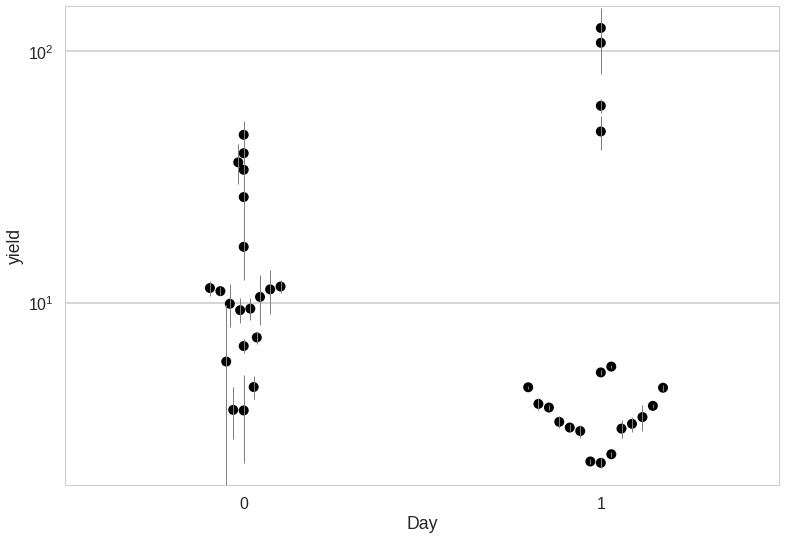

In [ ]:

day = day_finder('Results')
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

Results_m = pd.DataFrame(columns=['yield', 'std', 'Day'])
for i in range(start_day, day):
    Results_i = pd.DataFrame(columns=['yield', 'std', 'Day'])
    if start_day:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:days_range[i-1]]
    else:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    try:
        if start_day:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:days_range[i-1]]
        else:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    except:
        Results_i['std'] = 0
    Results_i['Day'] = i
    Results_m = pd.concat([Results_m, Results_i])

plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(1, 1)

#ax = sns.boxplot(x='Day', y='yield', data=Results_m, color='#4BC15F', fliersize=0)
ax = sns.swarmplot(x='Day', y='yield', data=Results_m, color='k', size=10)

if display_std:
    # Find the x,y coordinates for each point
    order = 0
    for point_pair in ax.collections:
        for x, y in point_pair.get_offsets():
            std = Results_m.sort_values(['Day', 'yield'], ignore_index=True)['std'][order]
            y_Result = Results_m.sort_values(['Day', 'yield'], ignore_index=True)['yield'][order]
            ax.arrow(x, y-(std/2), dx=0, dy=std, linewidth=1, zorder=4, width=0, color='grey')

            order += 1

    errors = Results_m['std']

if y_axis_log:
    ax.set_yscale("log")

ax

In [ ]:
fig.savefig(f'Day_{day-1}_Boxplot_Log_NoBox.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Boxplot_Log_NoBox.svg', format='svg', dpi=1200)

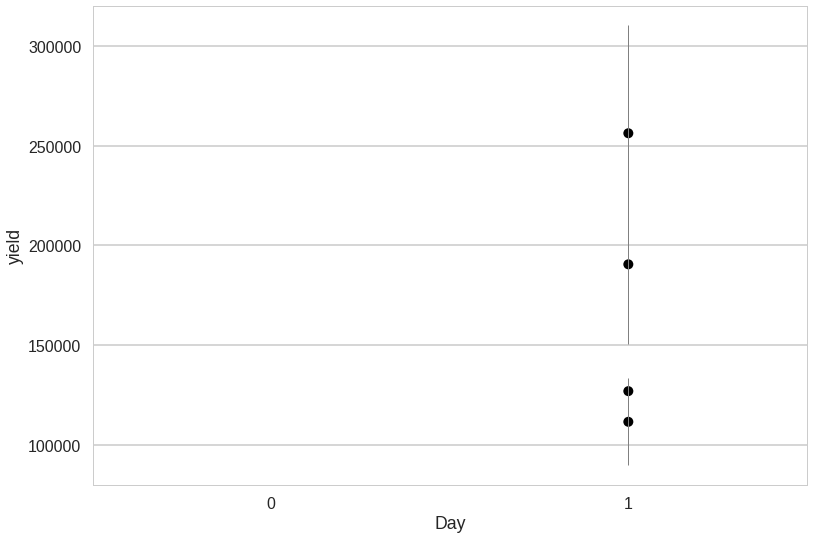

In [ ]:

day = day_finder('Results')
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

Results_m = pd.DataFrame(columns=['yield', 'std', 'Day'])
for i in range(start_day, day):
    Results_i = pd.DataFrame(columns=['yield', 'std', 'Day'])
    if start_day:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:days_range[i-1]]
    else:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    try:
        if start_day:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:days_range[i-1]]
        else:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    except:
        Results_i['std'] = 0
    Results_i['Day'] = i
    Results_m = pd.concat([Results_m, Results_i])

plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(1, 1)

ax = sns.boxplot(x='Day', y='yield', data=Results_m, color='#4BC15F', fliersize=0)
ax = sns.swarmplot(x='Day', y='yield', data=Results_m, color='k', size=10)

if display_std:
    # Find the x,y coordinates for each point
    order = 0
    for point_pair in ax.collections:
        for x, y in point_pair.get_offsets():
            std = Results_m.sort_values(['Day', 'yield'], ignore_index=True)['std'][order]
            y_Result = Results_m.sort_values(['Day', 'yield'], ignore_index=True)['yield'][order]
            ax.arrow(x, y-(std/2), dx=0, dy=std, linewidth=1, zorder=4, width=0, color='grey')

            order += 1

    errors = Results_m['std']


ax.set_ylim(bottom = 80000, top=320000)
ax

In [ ]:
fig.savefig(f'Day_{day-1}_Boxplot_Top.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Boxplot_Top.svg', format='svg', dpi=1200)

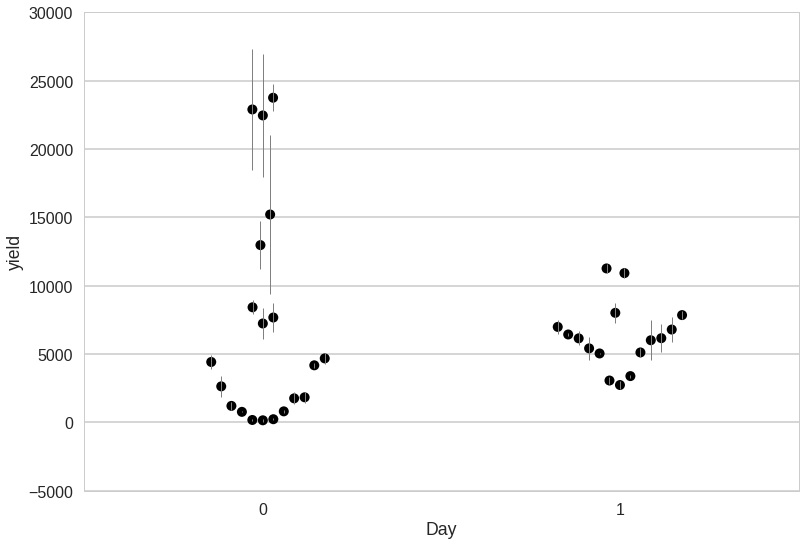

In [ ]:

day = day_finder('Results')
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

Results_m = pd.DataFrame(columns=['yield', 'std', 'Day'])
for i in range(start_day, day):
    Results_i = pd.DataFrame(columns=['yield', 'std', 'Day'])
    if start_day:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:days_range[i-1]]
    else:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    try:
        if start_day:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:days_range[i-1]]
        else:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    except:
        Results_i['std'] = 0
    Results_i['Day'] = i
    Results_m = pd.concat([Results_m, Results_i])

plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(1, 1)

#ax = sns.boxplot(x='Day', y='yield', data=Results_m, color='#4BC15F', fliersize=0)
ax = sns.swarmplot(x='Day', y='yield', data=Results_m, color='k', size=10)

if display_std:
    # Find the x,y coordinates for each point
    order = 0
    for point_pair in ax.collections:
        for x, y in point_pair.get_offsets():
            std = Results_m.sort_values(['Day', 'yield'], ignore_index=True)['std'][order]
            y_Result = Results_m.sort_values(['Day', 'yield'], ignore_index=True)['yield'][order]
            ax.arrow(x, y-(std/2), dx=0, dy=std, linewidth=1, zorder=4, width=0, color='grey')

            order += 1

    errors = Results_m['std']

ax.set_ylim(bottom = -5000, top=30000)
ax

In [ ]:
fig.savefig(f'Day_{day-1}_Boxplot_Down.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Boxplot_Down.svg', format='svg', dpi=1200)

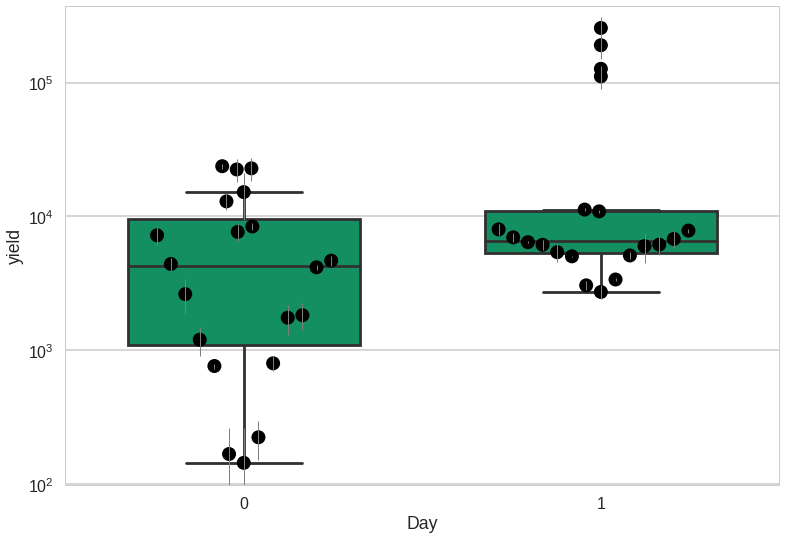

In [ ]:
day = day_finder('Results')
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

Results_m = pd.DataFrame(columns=['yield', 'std', 'Day'])
for i in range(start_day, day):
    Results_i = pd.DataFrame(columns=['yield', 'std', 'Day'])
    if start_day:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:days_range[i-1]]
    else:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    try:
        if start_day:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:days_range[i-1]]
        else:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    except:
        Results_i['std'] = 0
    Results_i['Day'] = i
    Results_m = pd.concat([Results_m, Results_i])

plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(1, 1)

#ax = sns.boxplot(x='Day', y='yield', data=Results_m, color='#4BC15F', fliersize=0, width=0.65)
ax = sns.boxplot(x='Day', y='yield', data=Results_m, color='#00A368', fliersize=0, width=0.65)

ax = sns.swarmplot(x='Day', y='yield', data=Results_m, color='k', size=14)

if display_std:
    # Find the x,y coordinates for each point
    order = 0
    for point_pair in ax.collections:
        for x, y in point_pair.get_offsets():
            std = Results_m.sort_values(['Day', 'yield'], ignore_index=True)['std'][order]
            y_Result = Results_m.sort_values(['Day', 'yield'], ignore_index=True)['yield'][order]
            ax.arrow(x, y-(std/2), dx=0, dy=std, linewidth=1, zorder=4, width=0, color='grey')

            order += 1

    errors = Results_m['std']

ax.set_yscale("log")
#ax.set_ylim(top=170)

ax

In [ ]:
fig.savefig(f'#00A368_Day_{day-1}_Boxplot_Log.png', format='png', dpi=1200)
fig.savefig(f'#00A368_Day_{day-1}_Boxplot_Log.svg', format='svg', dpi=1200)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


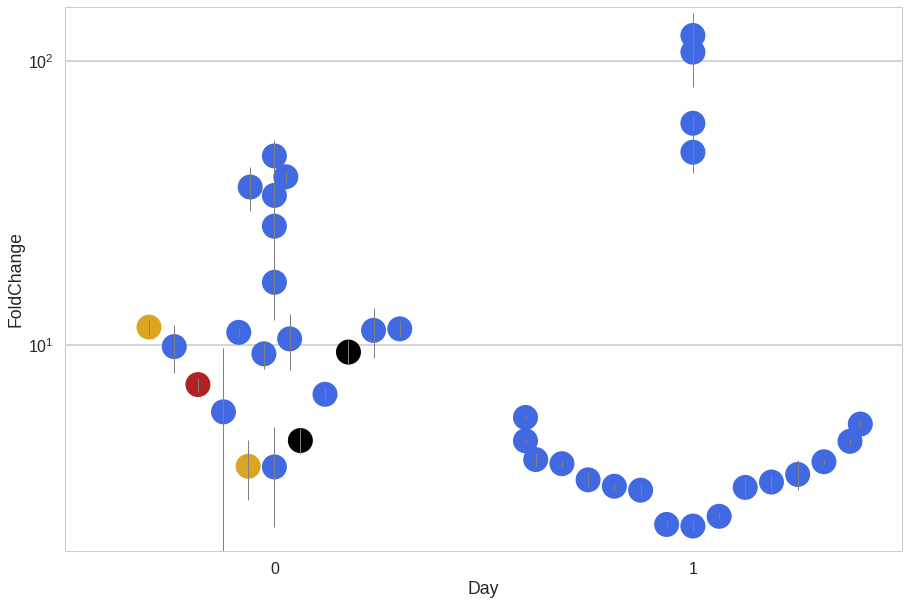

In [ ]:
# FC Data Plot (From BBO_Dev/LacI2.0)

display_std = True # if you have included "yield_std" column in Results.csv will show it else disply 0 for std

day = day_finder('Results')
start_day = (1, 0)[os.path.isfile('Results_0.csv')]
Results_m = pd.DataFrame(columns=['yield', 'std', 'Day', 'Plasmid'])
for i in range(start_day, day):
    Results_i = pd.DataFrame(columns=['yield', 'std', 'Day', 'Plasmid'])
    Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:days_range[i-1]]
    Results_i['Plasmid'] = pd.read_csv(f'Results_{i}.csv')['Plasmid'].iloc[0:days_range[i-1]]

    try:
        if start_day:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:days_range[i-1]]
        else:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    except:
        Results_i['std'] = 0
    Results_i['Day'] = i
    Results_m = pd.concat([Results_m, Results_i])
    
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(1, 1, figsize=(15,10))

#ax = sns.boxplot(x='Day', y='yield', data=Results_m, color='#4BC15F', fliersize=0)
ax = sns.swarmplot(x='Day', y='yield', hue='Plasmid', data=Results_m, size=25, palette=sns.color_palette(['goldenrod', 'royalblue' , 'firebrick', 'black'], 4))

if display_std:
    # Find the x,y coordinates for each point
    order = 0
    for point_pair in ax.collections:
        for x, y in point_pair.get_offsets():
            std = Results_m.sort_values(['Day', 'yield'], ignore_index=True)['std'][order]
            y_Result = Results_m.sort_values(['Day', 'yield'], ignore_index=True)['yield'][order]
            ax.arrow(x, y-(std/2), dx=0, dy=std, linewidth=1, zorder=4, width=0, color='grey')

            order += 1

    errors = Results_m['std']

ax.set_yscale("log")
ax.set_ylim(top=155)
ax.get_legend().remove()
ax.set_ylabel('FoldChange')
ax

In [ ]:
fig.savefig(f'Day_{day-1}_SwarmPlot_LacI_20_FoldChange_Log_v2.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_SwarmPlot_LacI_20_FoldChange_Log_v2.svg', format='svg', dpi=1200)

# Visualising Results For Each Metabolite

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file 
<p1><h2> How to use this part:</h2>
* just run all cells!
* you can change plotting parameter

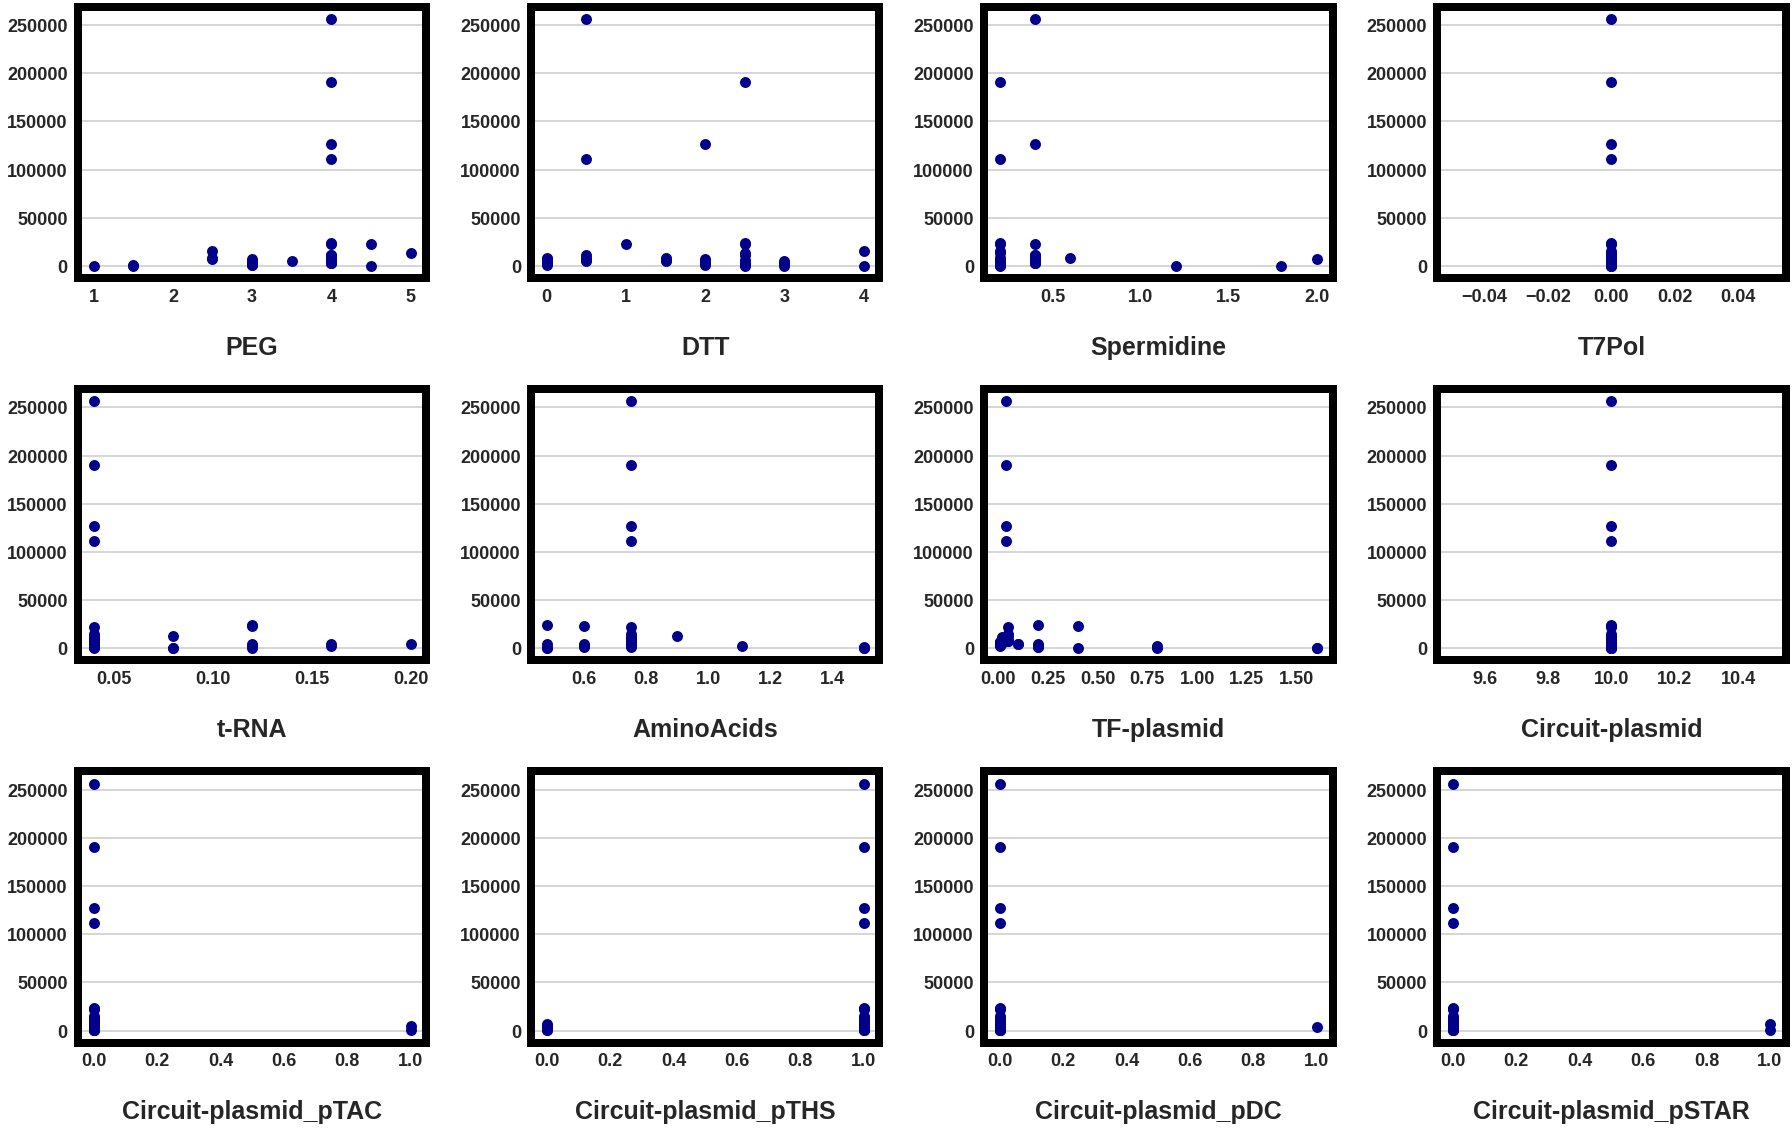

In [ ]:
desired_cols = []
day = day_finder('Results')
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day):
    if start_day:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

plt.style.use('seaborn-whitegrid')

num = len(desired_cols)
dim = math.ceil(math.sqrt(num))
data = pd.concat([aggregated_data_m, aggregated_label_m], axis=1)

import matplotlib as mpl


mpl.rcParams['axes.linewidth'] = 8.0 #set the value globally
mpl.rcParams['axes.edgecolor'] = 'black' #set the value globally
mpl.rcParams['xtick.major.pad'] = 10.0 #set the value globally
mpl.rcParams['ytick.major.pad'] = 10.0 #set the value globally

fig = plt.figure(figsize=(25,20))

for i in range(1, num+1):
    ax = plt.subplot(dim, dim, i)
    ax.xaxis.grid(False)
    ax = sns.scatterplot(x = desired_cols[i-1], y='yield', color='darkblue', data=data, s=120, linewidth=0)
    y_axis = ax.axes.get_yaxis()
    y_axis.set_label_text('foo')
    y_label = y_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    y_label.set_visible(False)
    #ax.xaxis.set_tick_params()
    plt.xticks(weight = 'bold', fontsize=18)
    plt.yticks(weight = 'bold', fontsize=18)

    plt.xlabel(desired_cols[i-1], labelpad=30 ,fontsize=25, weight='bold')


fig.tight_layout(h_pad=3, w_pad=3)

In [ ]:
fig.savefig(f'Day_{day-1}_Metabolite_Yield.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Metabolite_Yield.svg', format='svg', dpi=1200)

# Viualising Concentrations From Day_1 to Now

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file 
<p1><h2> How to use this part:</h2>
* just run all cells!
* you can change plotting parameter

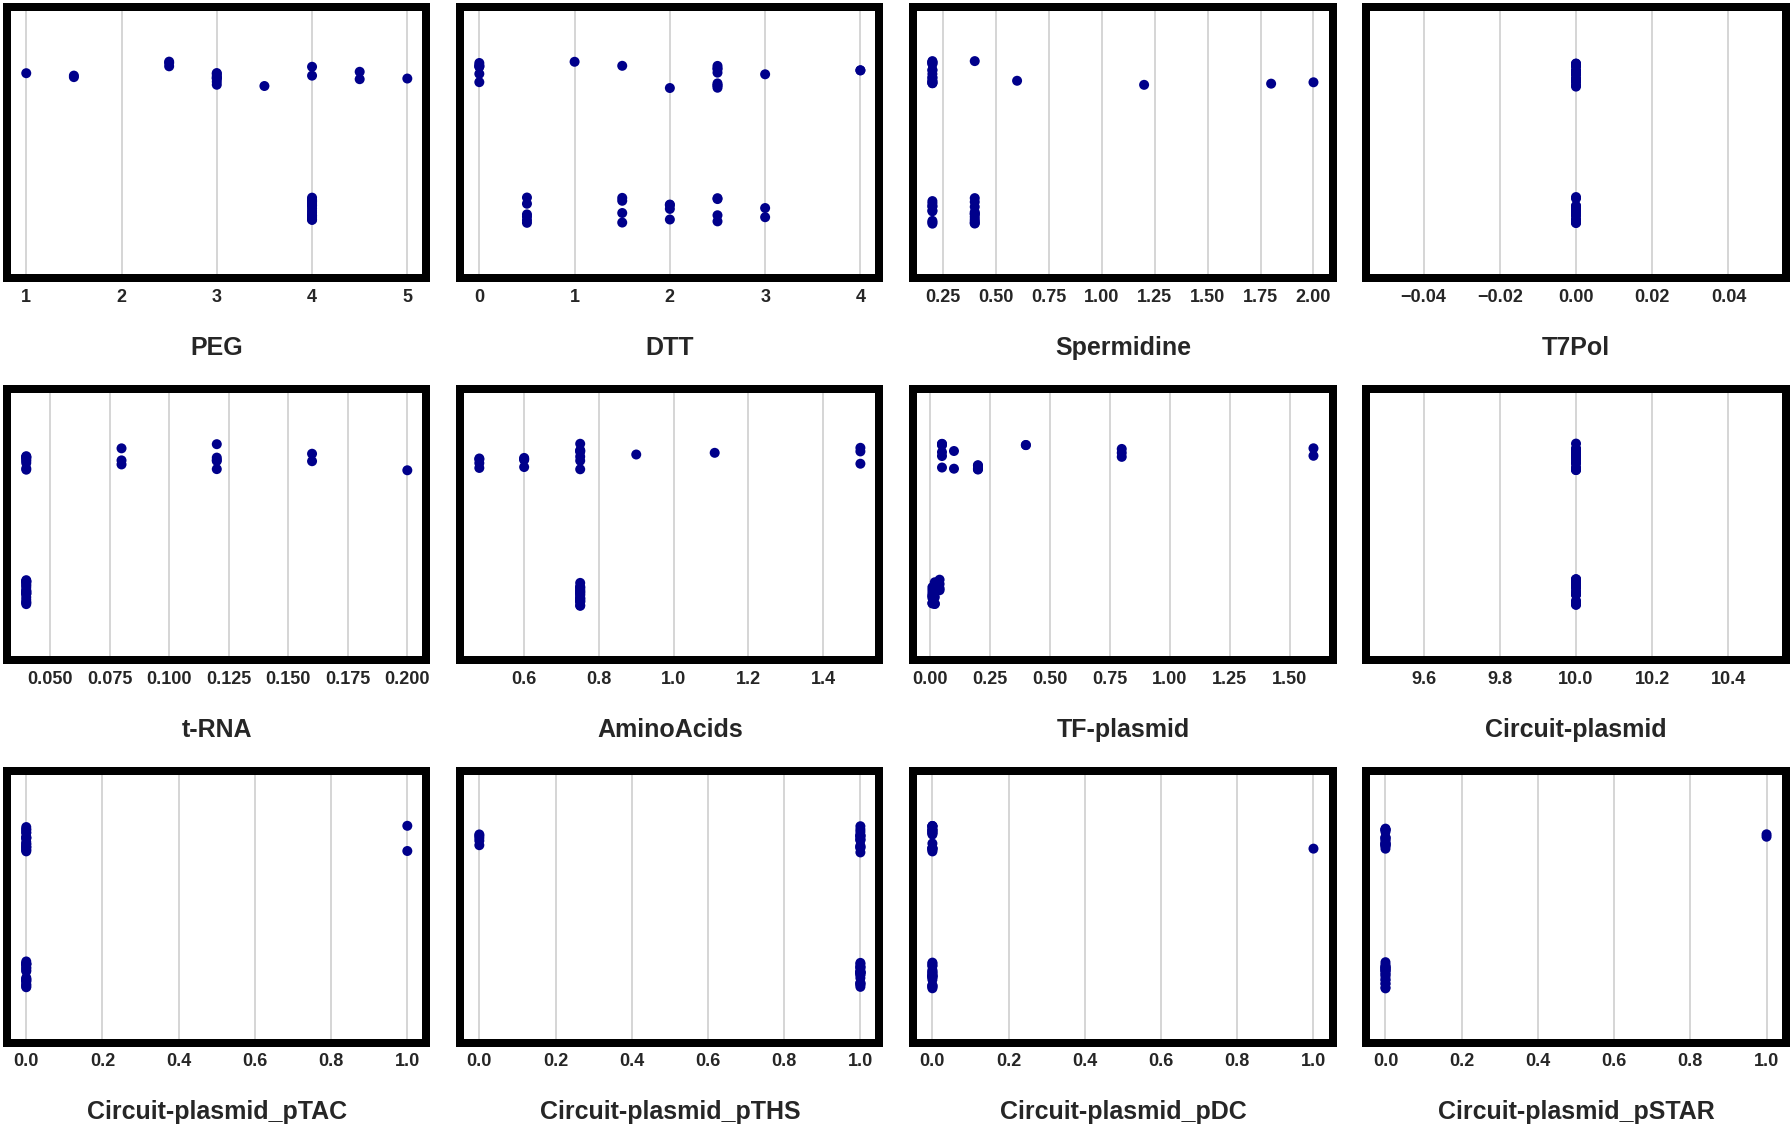

In [ ]:
data_all = pd.DataFrame(columns = list(concentrations_limits.keys())+['day'])
day = day_finder('Results')
desired_cols = []

# make column name:
desired_cols = []
for key, value in concentrations_limits.items():
    if not value['Alternatives']:
        desired_cols.append(key)
    else:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name

final_order = desired_cols

d = (1, 0)[os.path.isfile('Results_0.csv')]

while os.path.exists(f'Results_{d}.csv'):
    data = pd.read_csv(f'Results_{d}.csv')
    data = data[desired_cols]
    data = data.iloc[:days_range[d-1],:]
    data['day'] = f'Day_{d}'
    data_all = pd.concat([data_all, data]).reset_index(drop=True)
    d += 1

import matplotlib as mpl


mpl.rcParams['axes.linewidth'] = 8.0 #set the value globally
mpl.rcParams['axes.edgecolor'] = 'black' #set the value globally
mpl.rcParams['xtick.major.pad'] = 10.0 #set the value globally


num = len(desired_cols)
dim = math.ceil(math.sqrt(num))

fig = plt.figure(figsize=(25,20))
for i in range(1, num+1):
    ax = plt.subplot(dim, dim, i)
    ax = sns.stripplot(x=desired_cols[i-1], y="day", color='darkblue', data=data_all, s=10)
    y_axis = ax.axes.get_yaxis()
    y_axis.set_label_text('foo')
    y_label = y_axis.get_label()
    y_label.set_visible(False)

    ax.yaxis.set_ticklabels([])
    plt.xticks(weight = 'bold', fontsize=18)

    plt.xlabel(desired_cols[i-1], labelpad=30 ,fontsize=25, weight='bold')


fig.tight_layout(h_pad=3, w_pad=3)

In [ ]:
data_all

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,day,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,3.0,2.5,0.2,0,0.16,0.60,0.80,10,Day_0,0.0,1.0,0.0,0.0
1,3.0,0.0,0.2,0,0.04,0.60,0.80,10,Day_0,0.0,0.0,0.0,1.0
2,1.0,2.5,0.2,0,0.04,1.50,0.80,10,Day_0,0.0,1.0,0.0,0.0
3,4.0,2.5,0.2,0,0.12,0.60,0.40,10,Day_0,0.0,1.0,0.0,0.0
4,4.5,1.0,0.4,0,0.04,0.75,0.05,10,Day_0,0.0,1.0,0.0,0.0
5,3.0,2.5,0.2,0,0.04,1.50,0.20,10,Day_0,0.0,1.0,0.0,0.0
6,4.5,4.0,1.8,0,0.08,0.48,1.60,10,Day_0,1.0,0.0,0.0,0.0
7,2.5,0.0,2.0,0,0.04,0.75,0.05,10,Day_0,0.0,1.0,0.0,0.0
8,3.0,2.0,0.2,0,0.08,0.48,1.60,10,Day_0,0.0,1.0,0.0,0.0
9,1.5,3.0,1.2,0,0.12,1.50,0.40,10,Day_0,0.0,1.0,0.0,0.0


In [ ]:
fig.savefig(f'Day_{day-1}_Metabolite_Days.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Metabolite_Days.svg', format='svg', dpi=1200)

# Transform Volumes.csv to Table2Speech Compatible Input

<p1><h2> When to use this part:</h2>
* you have at least one Volumes_n.csv file located in Day_n Folder 
<p1><h2> How to use this part:</h2>
* specify in "which_day" your Volumes file is located
* run all other cells!
* you can download the Table2Speech_Volumes_n.csv file from Files

In [ ]:
which_day = 1 # i.e. Volumes_1.csv is in Day_1 Folder

In [ ]:
data = pd.read_csv(f'Day_{which_day}/Volumes_{which_day}.csv')

final_columns = []
columns_name = data.columns
for column in columns_name:
    if "_" in column:
        column_value = column.split('_')[0]
        column_to_add = data[column].unique()
        df_to_add = pd.DataFrame(columns = column_to_add,  data=np.zeros((len(data),len(column_to_add))))
        for i in range(len(data)):
            df_to_add[data[column].iloc[i,]][i] = data[column_value].iloc[i,]
        data = pd.concat([data, df_to_add], axis=1)
        final_columns.remove(column_value)
        final_columns += list(column_to_add)
    else:
        final_columns.append(column)

data = data[final_columns]
data

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,pTHS,Lysate,EnergyBuffer,IPTG-Water,water
0,1600.0,500.0,200.0,0.0,100.0,2500.0,200.0,200.0,6600.0,3500.0,500.0,4100.0
1,1600.0,500.0,200.0,0.0,100.0,2500.0,100.0,200.0,6600.0,3500.0,500.0,4200.0
2,1600.0,500.0,100.0,0.0,100.0,2500.0,200.0,200.0,6600.0,3500.0,500.0,4200.0
3,1600.0,500.0,100.0,0.0,100.0,2500.0,400.0,200.0,6600.0,3500.0,500.0,4000.0
4,1600.0,600.0,200.0,0.0,100.0,2500.0,200.0,200.0,6600.0,3500.0,500.0,4000.0
5,1600.0,600.0,200.0,0.0,100.0,2500.0,100.0,200.0,6600.0,3500.0,500.0,4100.0
6,1600.0,400.0,200.0,0.0,100.0,2500.0,400.0,200.0,6600.0,3500.0,500.0,4000.0
7,1600.0,400.0,200.0,0.0,100.0,2500.0,100.0,200.0,6600.0,3500.0,500.0,4300.0
8,1600.0,400.0,100.0,0.0,100.0,2500.0,100.0,200.0,6600.0,3500.0,500.0,4400.0
9,1600.0,400.0,100.0,0.0,100.0,2500.0,200.0,200.0,6600.0,3500.0,500.0,4300.0


In [ ]:
data.to_csv(f'Table2Speech_Volumes_{which_day}.csv', index=False)

# Transform Volumes.csv to ECHO liquid Handler Compatible Input

<p1><h2> When to use this part:</h2>
* you have at least one Volumes_n.csv file located in Day_n Folder 
<p1><h2> How to use this part:</h2>
* specify in "which_day" your Volumes file is located
* run all other cells!
* you can download the Echo_Input_n.csv file from Files

In [ ]:
which_day = 1 # i.e. Volumes_1.csv is in Day_1 Folder
plate_384_well = True   # your destination plate. If False the destination template will be 96-well plate. 
triplicate = False

In [ ]:
data = pd.read_csv(f'Day_{which_day}/Volumes_{which_day}.csv')

final_columns = []
columns_name = data.columns
for column in columns_name:
    if "_" in column:
        column_value = column.split('_')[0]
        column_to_add = data[column].unique()
        df_to_add = pd.DataFrame(columns = column_to_add,  data=np.zeros((len(data),len(column_to_add))))
        for i in range(len(data)):
            df_to_add[data[column].iloc[i,]][i] = data[column_value].iloc[i,]
        data = pd.concat([data, df_to_add], axis=1)
        final_columns.remove(column_value)
        final_columns += list(column_to_add)
    else:
        final_columns.append(column)

data = data[final_columns]
data

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,pDC,pTAC,pTHS,pSTAR,Lysate,EnergyBuffer,IPTG-Water,water
0,800.0,800.0,900.0,1300.0,100.0,2500.0,600.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0
1,1800.0,600.0,900.0,700.0,100.0,2500.0,50.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2550.0
2,800.0,400.0,1000.0,1000.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3300.0
3,1400.0,700.0,200.0,1000.0,100.0,2500.0,1000.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2300.0
4,600.0,300.0,800.0,400.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,3700.0
5,800.0,700.0,700.0,1800.0,100.0,2500.0,400.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0
6,1400.0,0.0,300.0,1300.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2800.0
7,1000.0,700.0,700.0,2000.0,100.0,2500.0,1000.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,1200.0
8,600.0,100.0,800.0,1600.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3400.0
9,1400.0,100.0,1000.0,1800.0,100.0,2500.0,1000.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,1300.0


In [ ]:
intermediate = put_volumes_to_384_wells(data, starting_well='A1', vertical=False, make_csv=False)
intermediate[1]

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,pDC,pTAC,pTHS,pSTAR,Lysate,EnergyBuffer,IPTG-Water,water,well_name
0,800.0,800.0,900.0,1300.0,100.0,2500.0,600.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0,A1
1,1800.0,600.0,900.0,700.0,100.0,2500.0,50.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2550.0,A2
2,800.0,400.0,1000.0,1000.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3300.0,A3
3,1400.0,700.0,200.0,1000.0,100.0,2500.0,1000.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2300.0,A4
4,600.0,300.0,800.0,400.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,3700.0,A5
5,800.0,700.0,700.0,1800.0,100.0,2500.0,400.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0,A6
6,1400.0,0.0,300.0,1300.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2800.0,A7
7,1000.0,700.0,700.0,2000.0,100.0,2500.0,1000.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,1200.0,A8
8,600.0,100.0,800.0,1600.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3400.0,A9
9,1400.0,100.0,1000.0,1800.0,100.0,2500.0,1000.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,1300.0,A10


In [ ]:
intermediate[0]['pTHS']

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
A,0.0,0.0,200.0,0.0,0.0,0.0,0.0,200.0,200.0,0.0,0.0,200.0,200.0,200.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
echo_input = source_to_destination(intermediate[1], desired_order=None, reset_index=True, check_zero=False)
echo_input[1]

,Source_Plate_Barcode,Source_Well,Destination_Plate_Barcode,Destination_Well,Transfer_Volume
0,Plate1,PEG well,destPlate1,A1,800.0
1,Plate1,PEG well,destPlate1,A2,1800.0
2,Plate1,PEG well,destPlate1,A3,800.0
3,Plate1,PEG well,destPlate1,A4,1400.0
4,Plate1,PEG well,destPlate1,A5,600.0
...,...,...,...,...,...
295,Plate1,water well,destPlate1,A16,3550.0
296,Plate1,water well,destPlate1,A17,2850.0
297,Plate1,water well,destPlate1,A18,4300.0
298,Plate1,water well,destPlate1,A19,1200.0


In [ ]:
echo_input[1].to_csv(f'Echo_Input_{which_day}.csv', index=False)

In [ ]:
echo_input[0]['PEG']

,Source_Plate_Barcode,Source_Well,Destination_Plate_Barcode,Destination_Well,Transfer_Volume
0,Plate1,PEG well,destPlate1,A1,800.0
1,Plate1,PEG well,destPlate1,A2,1800.0
2,Plate1,PEG well,destPlate1,A3,800.0
3,Plate1,PEG well,destPlate1,A4,1400.0
4,Plate1,PEG well,destPlate1,A5,600.0
5,Plate1,PEG well,destPlate1,A6,800.0
6,Plate1,PEG well,destPlate1,A7,1400.0
7,Plate1,PEG well,destPlate1,A8,1000.0
8,Plate1,PEG well,destPlate1,A9,600.0
9,Plate1,PEG well,destPlate1,A10,1400.0


# Find K Most Informative Combinations

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file </p1>
<p1><h2> How to use this part:</h2>
* specify in "k" i.e. how many combinations you want to get 
* run all other cells!
* you can download K_Most_Informative_Combinations.csv file from Files that contain index of most informative combinations for 5 iterations</p1>

In [ ]:
k = 20
number_try = 200000
number_to_select = 5
n_iter = 200

In [ ]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num>0:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)


aggregated_data_m

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,3.0,2.5,0.2,0,0.16,0.60,0.80,10,0,1,0,0
1,3.0,0.0,0.2,0,0.04,0.60,0.80,10,0,0,0,1
2,1.0,2.5,0.2,0,0.04,1.50,0.80,10,0,1,0,0
3,4.0,2.5,0.2,0,0.12,0.60,0.40,10,0,1,0,0
4,4.5,1.0,0.4,0,0.04,0.75,0.05,10,0,1,0,0
5,3.0,2.5,0.2,0,0.04,1.50,0.20,10,0,1,0,0
6,4.5,4.0,1.8,0,0.08,0.48,1.60,10,1,0,0,0
7,2.5,0.0,2.0,0,0.04,0.75,0.05,10,0,1,0,0
8,3.0,2.0,0.2,0,0.08,0.48,1.60,10,0,1,0,0
9,1.5,3.0,1.2,0,0.12,1.50,0.40,10,0,1,0,0


In [ ]:
# Create the grid search parameter and scoring functions
param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6 , 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

model = XGBRegressor(objective = 'reg:squarederror')
# create the grid search object
grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)
    
print('RandomSearchCV ...')
grid.fit(aggregated_data_m.values, aggregated_label_m.values)
results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
print('RandomSearchCV Done!')

RandomSearchCV ...
RandomSearchCV Done!


In [ ]:
indexs = []
num = 0
while num < number_try:
    numbers = set()
    while len(numbers) < k:
        numbers.add(random.randint(0, len(aggregated_data_m)-1))
    indexs.append(numbers)
    num += 1

In [ ]:
performance = []
best_param = results.params.iloc[0,]
all_set = set(range(len(aggregated_data_m)))
counter = 0
for index in indexs:
    counter += 1
    if counter%100 == 0:print(counter)
    index_test = all_set - index
    index_test = list(index_test)
    index = list(index)
    model = XGBRegressor(objective = 'reg:squarederror', **best_param)
    model.fit(aggregated_data_m.iloc[index].values, aggregated_label_m.iloc[index].values)
    performance.append(spearmanr(model.predict(aggregated_data_m.iloc[index_test].values), aggregated_label_m.iloc[index_test].values).correlation**2)

performance = np.array(performance)

In [ ]:
ind = np.argpartition(performance, -number_to_select)[-number_to_select:]
performance[ind]

array([0.94284069, 0.94945282, 0.94584599, 0.95536337, 0.9642354 ])

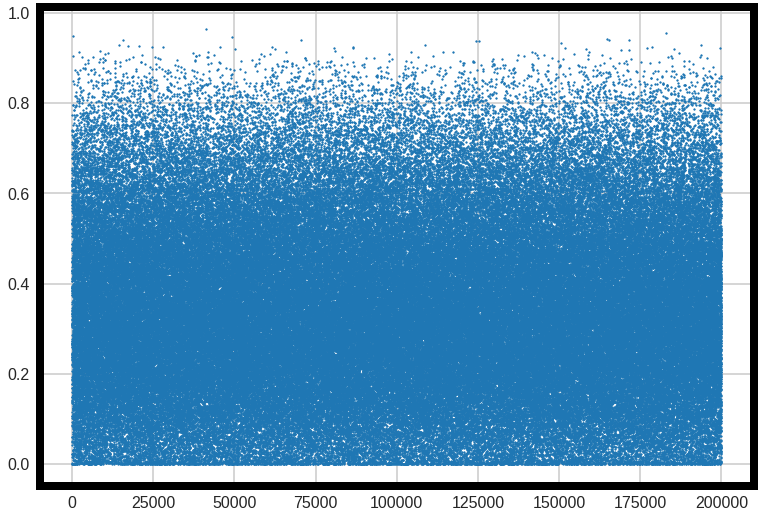

In [ ]:
plt.scatter(range(len(performance)), performance, s=3)

In [ ]:
df_perfomance = pd.DataFrame({'performance':performance, 'index_values':indexs}).sort_values('performance', ascending=False)
df_perfomance.iloc[0:5, :]

,performance,index_values
41299,0.964235,"{0, 33, 35, 4, 5, 6, 37, 9, 13, 16, 18, 20, 21..."
182945,0.955363,"{1, 34, 35, 36, 5, 6, 39, 37, 38, 4, 12, 13, 1..."
342,0.949453,"{1, 34, 35, 5, 38, 7, 39, 6, 37, 13, 14, 15, 1..."
49317,0.945846,"{33, 35, 3, 5, 6, 39, 8, 38, 10, 11, 13, 16, 1..."
164745,0.942841,"{0, 1, 34, 2, 36, 35, 6, 39, 38, 10, 13, 15, 1..."


In [ ]:
df_perfomance.iloc[0:5, :].index_values

41299     {0, 33, 35, 4, 5, 6, 37, 9, 13, 16, 18, 20, 21...
182945    {1, 34, 35, 36, 5, 6, 39, 37, 38, 4, 12, 13, 1...
342       {1, 34, 35, 5, 38, 7, 39, 6, 37, 13, 14, 15, 1...
49317     {33, 35, 3, 5, 6, 39, 8, 38, 10, 11, 13, 16, 1...
164745    {0, 1, 34, 2, 36, 35, 6, 39, 38, 10, 13, 15, 1...
Name: index_values, dtype: object

In [ ]:
for i, index in enumerate(df_perfomance.iloc[0:5, :].index_values):
    aggregated_data_m.iloc[list(index),:].to_csv(f'{k}_Most_Informative_Combinations_Rank{i+1}.csv', index=False)

# Find Feature Importances


<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file </p1>
<p1><h2> How to use this part:</h2>
* run all cells!
* you can download importance_df.csv  from Files</p1>

In [ ]:
n_iter = 200

In [ ]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

In [ ]:
importance_list = []
print('This may takes minutes!')

for day_i in range(start_day, day+1):
    aggregated_data_m = pd.DataFrame(columns=desired_cols)
    aggregated_label_m = pd.DataFrame(columns=['yield'])

    for num in range(start_day, day_i + 1):
        if start_day or num>0:
            data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
        else:
            data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

        aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
        aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

    # Create the grid search parameter and scoring functions
    param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6 , 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

    # creat estimator
    model = XGBRegressor(objective = 'reg:squarederror')

    # create the grid search object
    grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)
    
    print('RandomSearchCV ...', day_i)
    grid.fit(aggregated_data_m.values, aggregated_label_m.values)
    results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
    print('RandomSearchCV Done!')

    model = XGBRegressor(objective = 'reg:squarederror', **results.params.iloc[0,])
    model.fit(aggregated_data_m.values, aggregated_label_m.values)
    importance_list.append(model.feature_importances_)

This may takes minutes!
RandomSearchCV ... 0
RandomSearchCV Done!
RandomSearchCV ... 1
RandomSearchCV Done!


In [ ]:
importance_df = pd.DataFrame(importance_list, columns=aggregated_data_m.columns)
importance_df

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,0.261437,0.173461,0.196508,0.0,0.029889,0.062853,0.188672,0.0,0.0,0.078447,0.008328,0.000404
1,0.041907,0.026547,0.020724,0.0,0.006081,0.002890,0.899828,0.0,0.0,0.002022,0.000000,0.000000


In [ ]:
importance_df.to_csv('importance_df.csv', index=False)

* find feature importance through 
sklearn.feature_selection.mutual_info_regression

In [ ]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler_x = StandardScaler()
X = scaler_x.fit_transform(aggregated_data_m.values)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(aggregated_label_m.values)

In [ ]:
importance_df_sklearn = pd.DataFrame(mutual_info_regression(X, y)).T
importance_df_sklearn.columns = aggregated_data_m.columns
importance_df_sklearn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,0.134853,0.160945,0.0,6.661338e-16,0.0,0.044972,0.168253,6.661338e-16,0.0,0.031441,0.016667,0.0


In [ ]:
importance_df_sklearn.to_csv('importance_df_sklearn.csv', index=False)


# Find NonLinear Interactions

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file </p1>
<p1><h2> How to use this part:</h2>
* run all cells!
* you can download Interactions.png from Files</p1>

In [ ]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num>0:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)


aggregated_data_m

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,3.0,2.5,0.2,0,0.16,0.60,0.80,10,0,1,0,0
1,3.0,0.0,0.2,0,0.04,0.60,0.80,10,0,0,0,1
2,1.0,2.5,0.2,0,0.04,1.50,0.80,10,0,1,0,0
3,4.0,2.5,0.2,0,0.12,0.60,0.40,10,0,1,0,0
4,4.5,1.0,0.4,0,0.04,0.75,0.05,10,0,1,0,0
5,3.0,2.5,0.2,0,0.04,1.50,0.20,10,0,1,0,0
6,4.5,4.0,1.8,0,0.08,0.48,1.60,10,1,0,0,0
7,2.5,0.0,2.0,0,0.04,0.75,0.05,10,0,1,0,0
8,3.0,2.0,0.2,0,0.08,0.48,1.60,10,0,1,0,0
9,1.5,3.0,1.2,0,0.12,1.50,0.40,10,0,1,0,0


In [ ]:
from sklearn.linear_model import LinearRegression
from itertools import combinations

model = LinearRegression()
model.fit(aggregated_data_m.values, aggregated_label_m.values)
baseline_score = pearsonr(pd.DataFrame(model.predict(aggregated_data_m.values))[0] ,aggregated_label_m['yield'])
baseline_score

(0.30901618224443067, 0.05235566180158596)

In [ ]:
interaction_scores = {}
for i in combinations(aggregated_data_m.columns, 2):
    X = pd.concat([aggregated_data_m, (aggregated_data_m[i[0]] * aggregated_data_m[i[1]])], axis=1)
    y = aggregated_label_m

    model = LinearRegression()
    model.fit(X.values, y.values)
    score = pearsonr(pd.DataFrame(model.predict(X.values))[0] ,y['yield'])

    interaction_scores[i] = score

In [ ]:
interactions_df = pd.DataFrame(data=np.zeros([len(aggregated_data_m.columns), len(aggregated_data_m.columns)]), columns=aggregated_data_m.columns, index=aggregated_data_m.columns)

for columns, value in interaction_scores.items():
    diff = value[0] - baseline_score[0]
    interactions_df[columns[0]][columns[1]] = diff

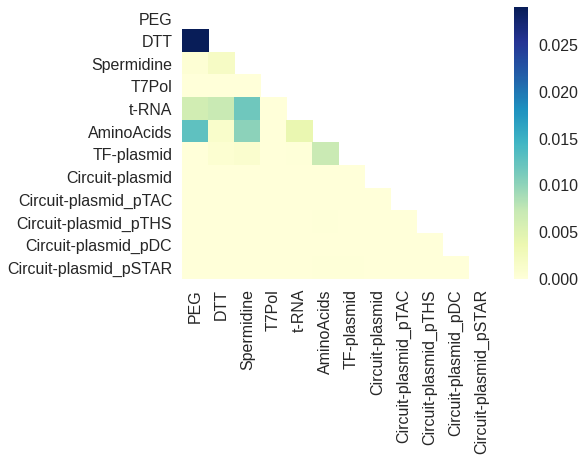

In [ ]:
corr = np.corrcoef(np.random.randn(len(aggregated_data_m.columns), 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (7,5))
ax = sns.heatmap(interactions_df, mask=mask, cmap='YlGnBu')

In [ ]:
fig.savefig('Interactions.png', format='png', dpi=1200)
fig.savefig('Interactions.svg', format='svg', dpi=1200)